#### [RL-X-04]
## OpenAI gym FrozenLake-v0 (stochastic)
_Value Iteration Algorithm_
---
[FrozenLake-v0 doc](https://gym.openai.com/envs/FrozenLake-v0/)

[FrozenLake-v0 src](https://github.com/openai/gym/tree/master/gym/envs/toy_text/frozen_lake.py)

---

### 1. Funciones V y Q
---
La **función de Valor** (_Value function_), **V(s)**, representa **cómo de bueno** es para el agente encontrarse en un determinado estado. Es igual al **retorno** (recompensa total futura) empezando desde dicho estado _s_.

Dado que el retorno puede ser distinto en cada episodio, empleamos la **esperanza matemática** del retorno con descuento promediando múltiples episodios (sumatorio de la probabilidad de cada suceso aleatorio por el valor de dicho suceso).

Para un entorno estocástico, tendremos que:

<br><img src="funcion_v.png"/><br>


La función de Valor depende de la política (_policy_) seguida por el agente para tomar acciones:

<br><img src="value_function.png" width=400/><br>

donde **T** es la longitud del episodio (_steps_) y **𝛾** el factor de descuento (_discount factor_) con valor ```[0,1)```. **E(x)** representa la esperanza matemática ó valor medio de una variable aleatoria _x_.

Dado que pueden existir múltiples políticas, existe una **función de Valor óptima** que presentará el valor más alto para cada uno de los diferentes estados:

<br><img src="value_function_star.png" width=400/><br>

Siendo la **política óptima** la que se corresponda con la **función de Valor óptima**:

<br><img src="policy_star.png" width=400/><br>

Por otro lado, relacionando nuestra nueva **función de Valor** con la **función Q**, que es una indicación de **cómo de bueno** es realizar una acción estando en un estado determinado, obtendremos:

<br><img src="value_q_star.png" width=400/><br>

Y si conocemos la **función Q óptima**, la **política óptima** se puede extraer facilmente eligiendo la acción que nos proporcione el mejor valor de **Q(s,a)** para un estado _s_.

<br><img src="policy_q_star.png" width=400/><br>

Finalmente, relacionando las ecuaciones anteriores con la **ecuación de Bellman**, llegaremos a:

<br><img src="value_bellman.png" width=450/><br>



### 2. Value Iteration
---
El método de **Value Iteration** trata de computar la **función de Valor óptima** de los estados a partir de estimaciones sucesivas de **V(s)**. Partiendo de valores arbitrarios de **V(s)** (por ejemplo, cero), se irá actualizando el valor de cada estado (calculando Q(s, a)) hasta que la función **converja**.

De las ecuaciones anteriores observamos que necesitamos conocer la tabla de transiciones **p** del entorno. Esta tabla contiene las probabilidades de "saltar" desde un estado a otro tras tomar una determinada acción. Es por ello que se trata de un método **model-based**, donde podremos calcular dicha función de Valor óptima y la política a seguir antes de que el agente interaccione con el entorno. En contraposición, con los métodos **model-free**, el agente debe interactuar con el entorno para ir obteniendo información de él que le lleve a tomar mejores decisiones.

<br>

##### Algoritmo:

<br><img src="value_iter_algo.png" width=600/><br>


### 3. Implementación
#### 3.1. El modelo (agente)
---

In [2]:
import torch
import numpy as np

class FrozenLakeAgent_VI():
    """Agent class for deterministic/stochastic FrozenLake environment.
    
       Implementation fo the value-iteration algorithm.
    """
    def __init__(self, env, gamma=1.0):
        self._env = env
        self._nA = env.action_space.n
        self._nS = env.observation_space.n
        self._P = env.P
        self._gamma = gamma
        self._state = 0
        self._V = torch.zeros(self._nS)

    @property
    def state(self):
        return self._state
    
    @state.setter
    def state(self, s):
        self._state = s
        
    def reset(self, state=0):
        self._state = state
        
    def select_action(self):
        """Selecciona la acción que maximiza Q(s,a) para el estado actual."""
        return np.argmax([self.get_action_value(self._state, a_) 
                          for a_ in range(self._nA)])
    
    def get_action_value(self, s, a):
        return sum([p * (r + self._gamma * self._V[s_]) for p, s_, r, _ in self._P[s][a]])

    def value_iteration(self):
        """Actualiza el valor de los estados al máximo de los Q(s,a) del estado."""
        for s_ in range(self._nS):
            self._V[s_] = max([self.get_action_value(s_, a_)
                                for a_ in range(self._env.action_space.n)])
    """
    def train(self, eps=1E-12, num_iter=0, output=True):
        #Estimates the V values of the environment.
        #By default, the loop iterates until convergence.
        #Alternatively, you can supply number of iterations
        
        if output: print("Training...")
        
        # Initialize V values of every state
        self._V = torch.zeros(self._nS)
        
        # repeat until convergence or number of iterations
        niter = 0
        while True:
            new_V = torch.zeros(self._nS)
            for s in range(self._nS): # for every state
                Qs = torch.zeros(self._nA)
                for a in range(self._nA): # for every action
                    Qs[a] = self.get_action_value(s, a)
                new_V[s] = torch.max(Qs)
            niter += 1
            convg = torch.square(self._V - new_V).mean().item() # convergence: Mean Square Error
            self._V = new_V.detach().clone() # update V values
            if num_iter:
                if niter == num_iter: break
            elif convg < eps: break
        
        if output: print(f"Num of iterations: {niter}\nConvergence: {convg:.6f}")
    """            
    def load_model(self, file_name):
        nV = np.loadtxt(file_name, dtype=np.float32, delimiter=";")
        self._V = torch.from_numpy(nV)
        
    def save_model(self, file_name):
        np.savetxt(file_name, self._V.detach().cpu().numpy(), delimiter=";")
        
    def print_model(self):
        # show V-values
        print("\nV-values:")
        print("=" * 9)        
        for r in range(self._V.shape[0]):
            print(f"{r:02d}: {self._V[r]:.9f}")
            
    def get_policy(self):
        """Devuelve la política que maximiza el valor de Q(s,a)."""
        policy = np.zeros(self._nS, dtype=int)
        for s in range(self._nS):
            policy[s] = np.argmax([self.get_action_value(s, a_)
                                   for a_ in range(self._nA)])
        return policy
    
    def print_policy(self):
        policy = self.get_policy()
        arrows = ('←', '↓', '→', '↑')
        print("\nPolicy:")
        print("=" * 7, end="")        
        nsq = int(np.sqrt(self._nS))
        for s in range(self._nS):
            if s % nsq == 0: print()
            print(arrows[policy[s]], end=" ")

### 4. Entrenando el agente (recompensa media)
----
La forma de entrenar a nuestro agente será la siguiente: 
1. Actualizaremos la función valor de estado (V) del agente (value_iteration method)
2. Ejecutaremos una iteración de N episodios y calcularemos la recompensa media de dichos episodios
3. Repetiremos el proceso hasta alcanzar el valor umbral deseado de recompensa media

La siguiente celda crea la función encargada de lanzar cada una de las iteraciones compuestas de N episodios para testear el comportamiento del agente

In [3]:
from time import sleep

def process_iteration(agent, n, show=False, pause=.0):
    """Lanza una iteración de N episodios y devuelve la recompesa media."""
    it_rwd = 0
    for i in range(n):
        eps_rwd = 0.0

        state = agent._env.reset()
        if show:
            agent._env.render()
            sleep(pause)

        is_done = False
        while not is_done:
            action = agent.select_action()
            new_state, rwd, is_done, _ = agent._env.step(action)
            eps_rwd += rwd
            agent.state = new_state
            if show:
                agent._env.render()
                sleep(pause)

        it_rwd += eps_rwd

    return it_rwd/n

Creamos ahora el bucle principal de entrenamiento que finalizará cuando se alcance la convergencia. 

Vamos a usar **tensorboard** para registrar la recompensa media en cada iteración y poder visualizar el proceso de aprendizaje a medida que avanzan las iteraciones de entrenamiento.

In [4]:
%load_ext tensorboard

In [5]:
# Import the wrapper library
import sys
sys.path.insert(0, "../lib/gym_wrappers")
from frozen_lake_wrappers import FrozenLakeWinWrapper

import gym
from torch.utils.tensorboard import SummaryWriter

# -- TUNNING ----------------------------------------------------------------------
_TEST_EPISODES = 40
_GAMMA = 0.95  
_RWD_THRESHOLD = 0.9
# ---------------------------------------------------------------------------------

# create the environment wrapper
#env = FrozenLakeWinWrapper("Demo", slippery=True, render=False)
env = gym.make("FrozenLake-v0")

# the agent
agent = FrozenLakeAgent_VI(env, gamma=_GAMMA)

# ---------------------------------------------------------------------------------
# TRAINING
# ---------------------------------------------------------------------------------

# Tensorboard record file init
writer = SummaryWriter("runs/working_directory")

it = 0
best_rwd = 0.0
while best_rwd < _RWD_THRESHOLD:
    agent.value_iteration() # actualiza el valor de los estados

    it += 1 # iteración

    # lanza una iteración de N episodios y obtiene la recompensa media
    it_rwd = process_iteration(agent, _TEST_EPISODES)

    # guardamos la recompensa media para Tensorboard
    writer.add_scalar("reward", it_rwd, it)

    if it_rwd > best_rwd:
        print(f"Best reward updated {it_rwd:.2f} at iteration {it}")
        best_rwd = it_rwd

# Tensorboard file close
writer.close()
# ---------------------------------------------------------------------------------

# save model
print("\nSaving model... ", end="")
agent.save_model("frozenlake_VI_model.csv")
print("OK")

# show V-values
agent.print_model()
agent.print_policy()

pygame 2.0.1 (SDL 2.0.14, Python 3.8.10)
Hello from the pygame community. https://www.pygame.org/contribute.html
Best reward updated 0.28 at iteration 3
Best reward updated 0.33 at iteration 4
Best reward updated 0.45 at iteration 6
Best reward updated 0.57 at iteration 7
Best reward updated 0.60 at iteration 14
Best reward updated 0.82 at iteration 15
Best reward updated 0.90 at iteration 29

Saving model... OK

V-values:
00: 0.161732376
01: 0.140273377
02: 0.143842757
03: 0.122078776
04: 0.193592727
05: 0.000000000
06: 0.171827495
07: 0.000000000
08: 0.259216309
09: 0.367933512
10: 0.399298787
11: 0.000000000
12: 0.000000000
13: 0.504457831
14: 0.721452773
15: 0.000000000

Policy:
← ↑ ← ↑ 
← ← ← ← 
↑ ↓ ← ← 
← → ↓ ← 

In [6]:
tensorboard --logdir="runs"

### 5. Evaluando al agente
----
Vamos a resolver una serie de episodios con el modelo entrenado previamente para analizar cómo se comporta el agente en este entorno estocástico

IntProgress(value=0, description='Episodes [250]:', max=250, style=ProgressStyle(bar_color='#44a0fd'))

Cargando el modelo... OK

Episodes solved:  178
Average episodes solved:  0.712

Average steps:  43.72


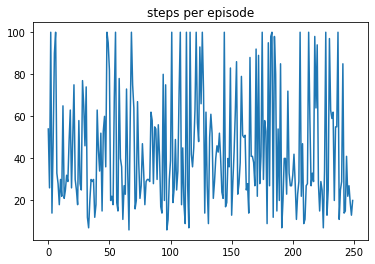


Average reward:  0.712


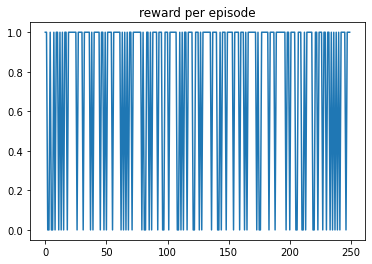

In [7]:
# Jupyter widgets
import ipywidgets as widgets

# Import the wrapper library
import sys
sys.path.insert(0, "../lib/gym_wrappers")
from frozen_lake_wrappers import FrozenLakeWinWrapper

import time
import torch
from matplotlib import pyplot as plt

# -- TUNNING ----------------------------------------------------------------------
_EPISODES = 250
_GAMMA = 1  
# ---------------------------------------------------------------------------------

# progress bar widget
w_bar = widgets.IntProgress(
    value=0,
    min=0,
    max=_EPISODES,
    description=f'Episodes [{_EPISODES}]:',
    bar_style='', # 'success', 'info', 'warning', 'danger' or ''
    style={'bar_color': '#44a0fd'},
    orientation='horizontal'
)
display(w_bar)

# create the environment wrapper
env = FrozenLakeWinWrapper("Demo", slippery=True, render=False)

# Agent
agent = FrozenLakeAgent_VI(env)

# load model
print("Cargando el modelo... ", end="")
agent.load_model("frozenlake_VI_model.csv")
print("OK")

# stats
episodes_rewards = []
episodes_steps = []
episodes_solved = []

for i in range(_EPISODES):
    # widget update
    w_bar.description = f'Episode [{i+1:03}]:'
    w_bar.value = i+1
    
    eps_steps = 0  # total episode steps
    eps_reward = 0 # total episode reward
    
    state = env.reset() # initial state
    agent.reset(state)
    
    done = False  # episode done?
    while not done:
        # perform action
        new_state, reward, done, _ = env.step(agent.select_action())
        
        # update agent state
        agent.state = new_state
        
        # update stats
        eps_steps += 1
        eps_reward += reward
        
    episodes_rewards.append(eps_reward)
    episodes_steps.append(eps_steps)
    episodes_solved.append(1 if env.goal else 0)
            
# show stats
print(f"\nEpisodes solved: ", sum(episodes_solved))
print(f"Average episodes solved: ", sum(episodes_solved)/len(episodes_solved))

print(f"\nAverage steps: ", sum(episodes_steps)/len(episodes_steps))
plt.plot(episodes_steps)
plt.title("steps per episode")
plt.show()

print(f"\nAverage reward: ", sum(episodes_rewards)/len(episodes_rewards))

plt.plot(episodes_rewards)
plt.title("reward per episode")
plt.show()

### 6. Visualizando el agente
----
De los resultados anteriores podemos comprobar que se trata de un rendimiento bastante decente para este entorno estocástico. En general, si analizamos la política del agente (mostrada al final del entrenamiento), éste va a tratar de evitar aquellas acciones que puedan provocar una caída en un hoyo. Por ello, el número de pasos hasta encontrar la salida es muy elevado (en promedio: ~40).

Vamos a ejecutar varios espisodios de muestra con la visualización activada

In [8]:
# -- TUNNING ----------------------------------------------------------------------
_EPISODES = 3
# ---------------------------------------------------------------------------------

# create the environment wrapper
env = FrozenLakeWinWrapper("Demo", slippery=True, sound=True)

env.set_im_goal('art/batt.png')

env.hole_color = (25, 25, 25)
env.grid_color = (220, 220, 255)
env.home_color = (200, 255, 200)
env.goal_color = (255, 200, 200)

# Agent
agent = FrozenLakeAgent_VI(env)

# load model
print("Cargando el modelo... ", end="")
agent.load_model("frozenlake_VI_model.csv")
print("OK")

for i in range(_EPISODES):
    print(f"\nEpisode: {i+1}... ", end="")
    
    # initial state
    state = env.reset() 
    agent.reset(state)
    
    env.run_once()
    time.sleep(1)
    
    done = False  # episode done?
    while env.is_alive and not done:
        # perform action
        new_state, reward, done, _ = env.step(agent.select_action())
        
        # update agent state
        agent.state = new_state
        
        # update window
        env.run_once()
        time.sleep(0.25)
    
    if env.goal: print("goal! ", end="")
    print("(episode done)")
    time.sleep(1)
    
    if not env.is_alive:
        break

# wait until window closes
while env.is_alive:
    env.run_once()

Cargando el modelo... OK

Episode: 1... goal! (episode done)

Episode: 2... goal! (episode done)

Episode: 3... goal! (episode done)
